

# Group Analysis - FOOOFed EEG Analysis: Rest

Apply FOOOF to resting state EEG data, and compare details between young and old group. 

Note:
- Subject 21 is broken (is a young subject)

In [1]:
%matplotlib inline
%config InlineBackend.figure_format='retina'

%load_ext autoreload

In [2]:
from os import listdir
from os.path import join as pjoin

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind, pearsonr

from fooof import FOOOFGroup
from fooof.analysis import get_band_peak_group
from fooof.core.funcs import expo_nk_function

In [3]:
# Import custom code for this analysis
%autoreload 2
from plts import *
from utils import *

In [4]:
plot_comp_scatter??

# Settings

In [4]:
# Set path to load results from
res_path = '/Users/tom/Documents/Research/1-Projects/fooof/2-Data/Results/'

# Set indices to separate groups
from settings import YNG_INDS, OLD_INDS

# Set average function to use
avg_func = np.nanmean
#avg_func = np.nanmedian

# Wether to save out plots or not
save_fig = False

print('Number of young subjects:  ', len(YNG_INDS))
print('Number of  old  subjects:  ', len(OLD_INDS))

Number of young subjects:   17
Number of  old  subjects:   14


## FOOOF

In [5]:
# Get files
files = listdir(pjoin(res_path, 'FOOOF'))
files = [file for file in files if 'RAW' in file]

In [6]:
# Load all subject FOOOFGroups
fg = FOOOFGroup()
fgs = []
for file in files:
    fg.load(file, pjoin(res_path, 'FOOOF'))
    fgs.append(fg.copy())

In [7]:
# Grab alphas from each subject
ch_ind = 28  # 28 is Oz
alphas = np.empty(shape=[len(fgs), 3])
for ind, fg in enumerate(fgs):
    #alphas[ind, :] = get_band_peak_group(fg.get_all_data('gaussian_params'), [7, 14], len(fg))[ch_ind, :]
    alphas[ind, :] = get_band_peak_group(fg.get_all_data('peak_params'), [7, 14], len(fg))[ch_ind, :]

In [8]:
# Grab aperiodic exponent from each subject
ch_ind = 47 # 47 is Cz
aps = np.empty(shape=[len(fgs), 2])
for ind, fg in enumerate(fgs):
    aps[ind, :] = fg.get_all_data('aperiodic_params')[ch_ind]
offs = aps[:, 0]
exps = aps[:, 1]

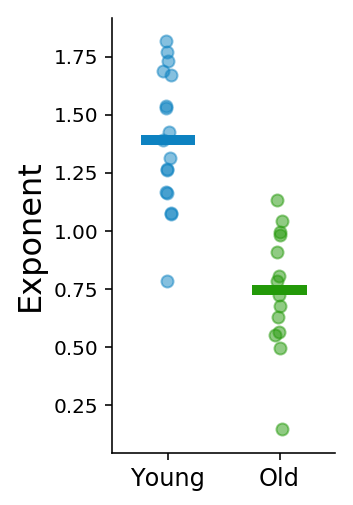

In [9]:
# Plot exponent comparison
plot_comp_scatter(exps, 'Exponent', save_fig=save_fig, save_name='exponents')

In [10]:
# Statistically test exponent difference
print_stat('Exponent t-test', *ttest_ind(exps[YNG_INDS], exps[OLD_INDS]))
print('Mean Difference: \t', np.mean(exps[YNG_INDS]) - np.mean(exps[OLD_INDS]))

Exponent t-test: 	  6.4173 	0.0000
Mean Difference: 	 0.6464927126166689


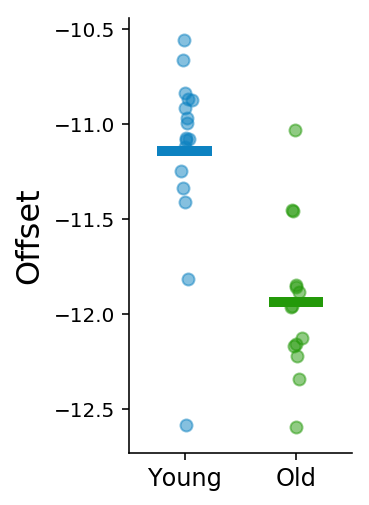

In [11]:
# Plot offset comparison
plot_comp_scatter(offs, 'Offset', save_fig=save_fig, save_name='Offsets')

In [12]:
# Statistically test offset difference
print_stat('Offset t-test', *ttest_ind(offs[YNG_INDS], offs[OLD_INDS]))
print('Mean Difference: \t', np.mean(offs[YNG_INDS]) - np.mean(offs[OLD_INDS]))

Offset t-test: 	  4.9424 	0.0000
Mean Difference: 	 0.7917959214298094


### Check total alpha power

'Total alpha power', from the FOOOF model, is the model results of the aperiodic + the alpha peak amplitude.

In [13]:
# Set the channel to extract alpha power from
ch_ind = 28 # Oz

# Collect the aperiodic parameters for each subject
oz_aps = np.empty(shape=[len(fgs), 2])
for ind, fg in enumerate(fgs):
    oz_aps[ind, :] = fg.get_all_data('aperiodic_params')[ch_ind]

# Calculate total alpha as the value of the BG function at alpha CF, please the amplitude of the alpha peak
tot_alphas = []
for bg, cf, amp in zip(oz_aps, alphas[:, 0], alphas[:, 1]):

    # If there is no alpha, get the aperiodic component at CF of 10, and set alpha amplitude to zero
    if np.isnan(cf):
        cf, amp = 10, 0
    
    # Calculate the value of the aperiodic function at the alpha-CF, and add the alpha-amp
    tot_alphas.append(expo_nk_function(np.array([cf]), *bg)[0] + amp)
    
tot_alphas = np.array(tot_alphas)

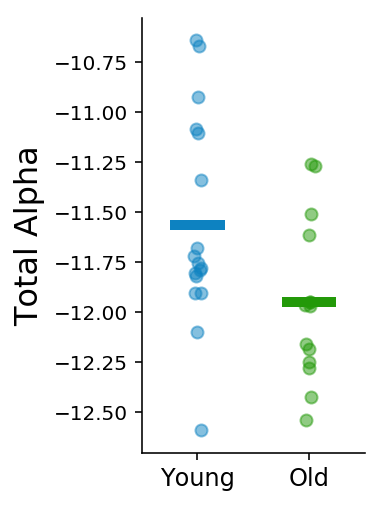

In [14]:
# Plot total alpha - total power values from the FOOOF model at individualzed alpha CFs
#  Note: this is equivalent to doing an individualed alpha frequency analysis, comparing total power
plot_comp_scatter(tot_alphas, 'Total Alpha', save_fig=save_fig, save_name='TotalAlpha')

In [15]:
print_stat('Total Alpha t-test', *ttest_ind(tot_alphas[YNG_INDS], tot_alphas[OLD_INDS]))
print('Mean Difference: \t', np.mean(tot_alphas[YNG_INDS]) - np.mean(tot_alphas[OLD_INDS]))

Total Alpha t-test: 	  2.2577 	0.0317
Mean Difference: 	 0.38697275132320286


### Check number of extracted oscillations

In [16]:
ch_ind = 28  # Oz
n_oscs = []
for fg in fgs:
    n_oscs.append(fg.get_results()[ch_ind].peak_params.shape[0])
n_oscs = np.array(n_oscs)

In [17]:
print('# Oscs Yng:', np.mean(n_oscs[YNG_INDS]))
print('# Oscs Old:', np.mean(n_oscs[OLD_INDS]))
print_stat('\n# Oscs Diff', *ttest_ind(n_oscs[YNG_INDS], n_oscs[OLD_INDS]))

# Oscs Yng: 4.176470588235294
# Oscs Old: 4.285714285714286

# Oscs Diff: 	 -0.2742 	0.7858


### Statistically Compare Peak Parameters

In [18]:
for d_ind, label in zip([0, 1, 2], ['CF', 'Amp', 'BW']):

    # Select data
    dat = alphas[:, d_ind]
    you_dat = list(dat[YNG_INDS][~np.isnan(dat[YNG_INDS])])# + [0] * sum(np.isnan(dat[YNG_INDS]))
    old_dat = list(dat[OLD_INDS][~np.isnan(dat[OLD_INDS])])# + [0] * sum(np.isnan(dat[OLD_INDS]))
    
    # Statistically compare and check average difference between groups
    print(label)
    #print('\t', ttest_ind(you_dat, old_dat))
    print_stat('\tDiff', *ttest_ind(you_dat, old_dat))
    print('\tMean Diff: ', np.mean(you_dat - np.mean(old_dat)))
    
# Check how many subjects, 
print('\nNumber of subjects with no alpha:')
print('\t Yng:\t', sum(np.isnan(dat[YNG_INDS])))
print('\t Old: \t', sum(np.isnan(dat[OLD_INDS])))

CF
	Diff: 	  1.7770 	0.0861
	Mean Diff:  0.9379448713720908
Amp
	Diff: 	  2.2084 	0.0353
	Mean Diff:  0.2939600809251015
BW
	Diff: 	  0.3260 	0.7468
	Mean Diff:  0.09310270018527585

Number of subjects with no alpha:
	 Yng:	 0
	 Old: 	 0


### Alpha - Center Frequency

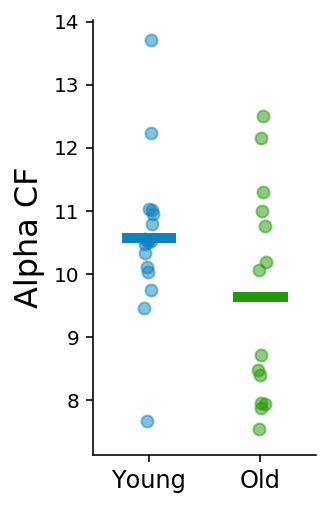

In [19]:
plot_comp_scatter(alphas[:, 0], 'Alpha CF', save_fig=save_fig, save_name='AlphaCF')

### Alpha - Amplitude

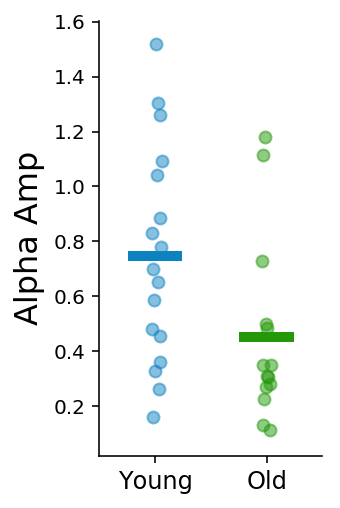

In [20]:
plot_comp_scatter(alphas[:, 1], 'Alpha Amp', save_fig=save_fig, save_name='AlphaAmp')

### Alpha - Bandwidth

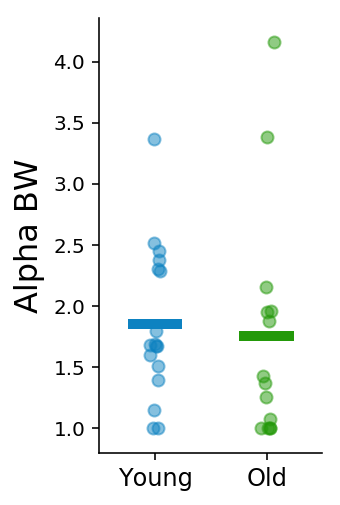

In [21]:
plot_comp_scatter(alphas[:, 2], 'Alpha BW', save_fig=save_fig, save_name='AlphaBW')

### Alpha Oscillations - Individual Variation

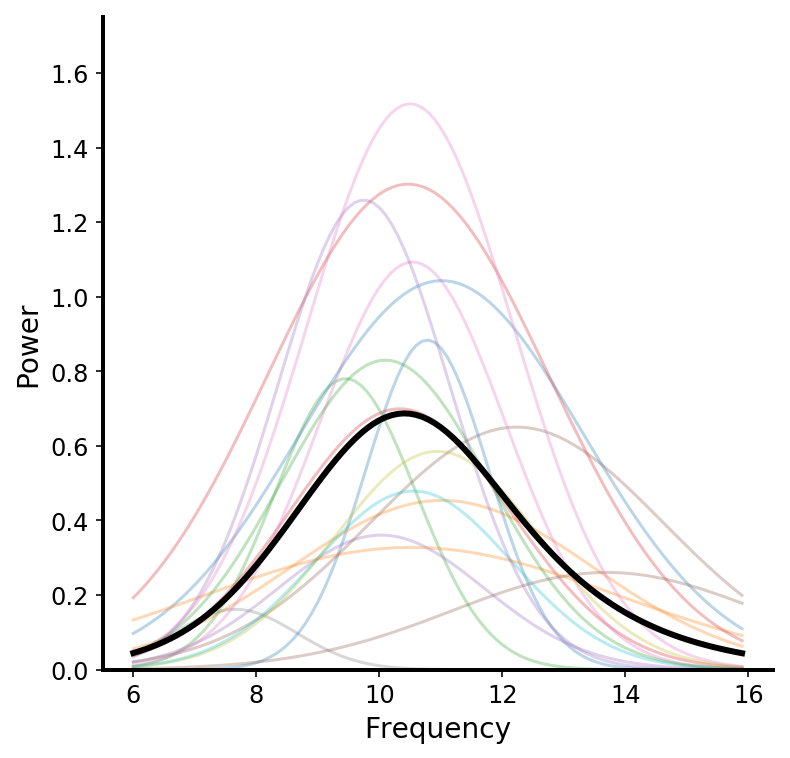

In [22]:
plot_oscillations(alphas[YNG_INDS, :], save_fig=save_fig, save_name='YoungAlphas')

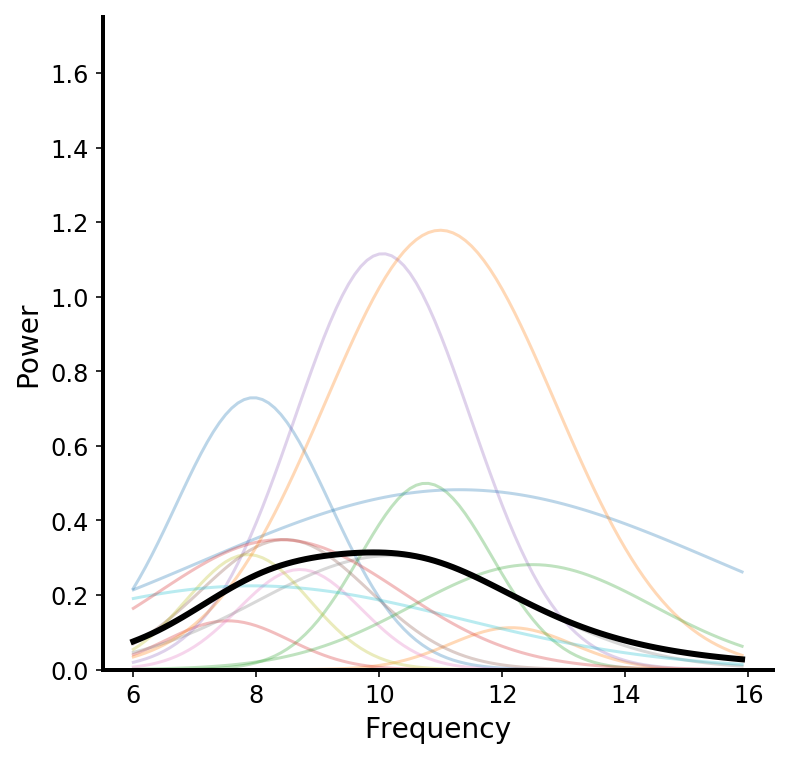

In [23]:
plot_oscillations(alphas[OLD_INDS, :], save_fig=save_fig, save_name='OldAlphas')

### Overlap of Individualized Alpha with Canonical Band



In [24]:
def calc_overlaps(alphas):
    """
    The approach to do this is taken from:
    https://stackoverflow.com/questions/32551610/overlapping-probability-of-two-normal-distribution-with-scipy
    """

    # Note: current approach presumes no NaNs
    overlaps = []
    mean, std = 10, 2

    for alpha in alphas:

        # Get individial CF - keep BW @ 2
        ind_mean, ind_std = alpha[0], 2

        # Normalize all deviations from canonical to be lower than 10 Hz
        if ind_mean <= mean:
            m1, std1, m2, std2 = ind_mean, ind_std, mean, std
            #flip = False
        else:
            m1, std1, m2, std2 = mean, std, ind_mean, ind_std
            #flip = True    

        intersect = get_intersect(m1, m2, std1, std2)
        overlap = get_overlap(intersect, m1, m2, std1, std2)
        
#         if flip:
#             overlap = 1 - overlap
#         else:
#             overlap = -(1 - overlap)
        
        overlaps.append(overlap)

    overlaps = np.array(overlaps)
    
    return overlaps

In [25]:
overlaps = calc_overlaps(alphas)

In [26]:
overlaps

array([0.6085693 , 0.59179301, 0.84988962, 0.53796082, 0.98881343,
       0.70156229, 0.74662154, 0.96295214, 0.59319918, 0.60611184,
       0.74465395, 0.80404933, 0.53290815, 0.68715094, 0.84519964,
       0.79877957, 0.89108263, 0.93307405, 0.99372535, 0.57594989,
       0.89211565, 0.5582788 , 0.81340185, 0.88960454, 0.79956157,
       0.89663882, 0.97988767, 0.90675743, 0.94968647, 0.35476199,
       0.90014462])

In [27]:
# Check average (overall) of overlaps
print('ALL avg overlap: ', np.mean(np.abs(overlaps)), '\n')

# Check average per yng & old group, and test difference
print('YNG avg overlap:', np.mean(overlaps[YNG_INDS]))
print('OLD avg overlap:', np.mean(overlaps[OLD_INDS]))

print_stat('\nDiff Overlap:', *ttest_ind(overlaps[YNG_INDS], overlaps[OLD_INDS]))

ALL avg overlap:  0.772093099304128 

YNG avg overlap: 0.8222735609714721
OLD avg overlap: 0.71115968156521

Diff Overlap:: 	  1.9155 	0.0653


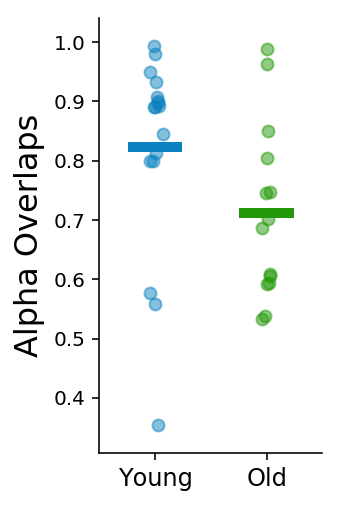

In [28]:
plot_comp_scatter(overlaps, 'Alpha Overlaps', save_fig=save_fig, save_name='AlphaOverlaps')

In [29]:
np.mean(np.abs(alphas[:, 0] - 10)[OLD_INDS])

1.5057816850555206

In [30]:
np.mean(np.abs(alphas[:, 0] - 10)[YNG_INDS])

0.9351214611094983

#### Plot Overlap

Plot for an example case, using the average deviation from 10 Hz. 

In [31]:
# Get the average deviation from center of 10 Hz
avg_deviation = np.mean(np.abs(alphas[:, 0] - 10))

In [32]:
# Compare canonical 10 +/- 2, with a gaussian centered with average deviation
#  Note: in this approach, average deviation shifted below 10 Hz
#    This is arbitrary - still captures deviations above 10 - could be equivalently calculated that way
m1, m2, std1, std2 = 10-avg_deviation, 10, 2, 2
r = get_intersect(m1, m2, std1, std2)

# Check the overlap of the 'average' subject
print(get_overlap(r, m1, m2, std1, std2))

0.7655430842455089


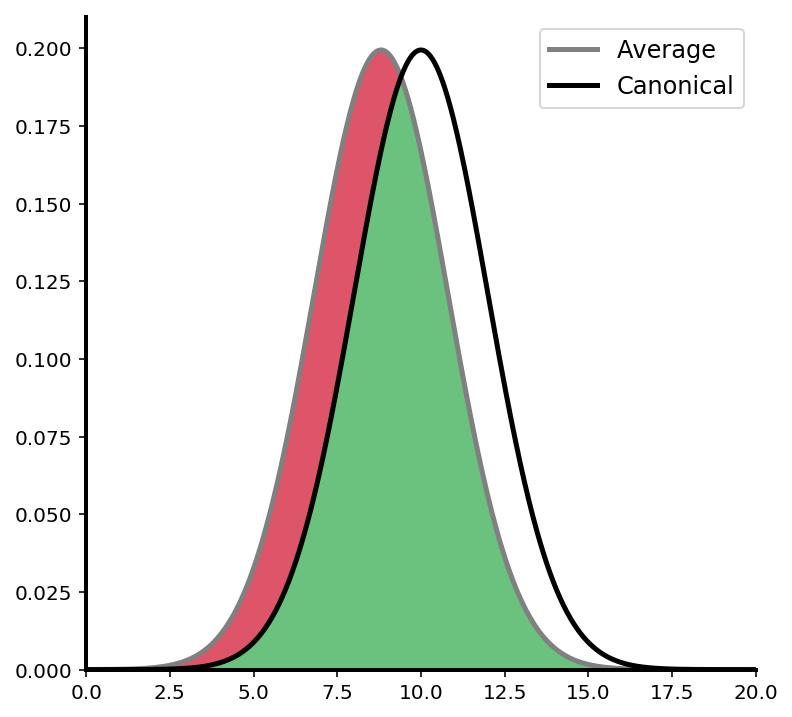

In [33]:
# Plot the overlap of canonical and average shifted alpha
plot_overlap(m1, m2, std1, std2, save_fig=save_fig, save_name='CanonicalCompare')

### Compare 'Frequency Specific' Differences from Aperiodic

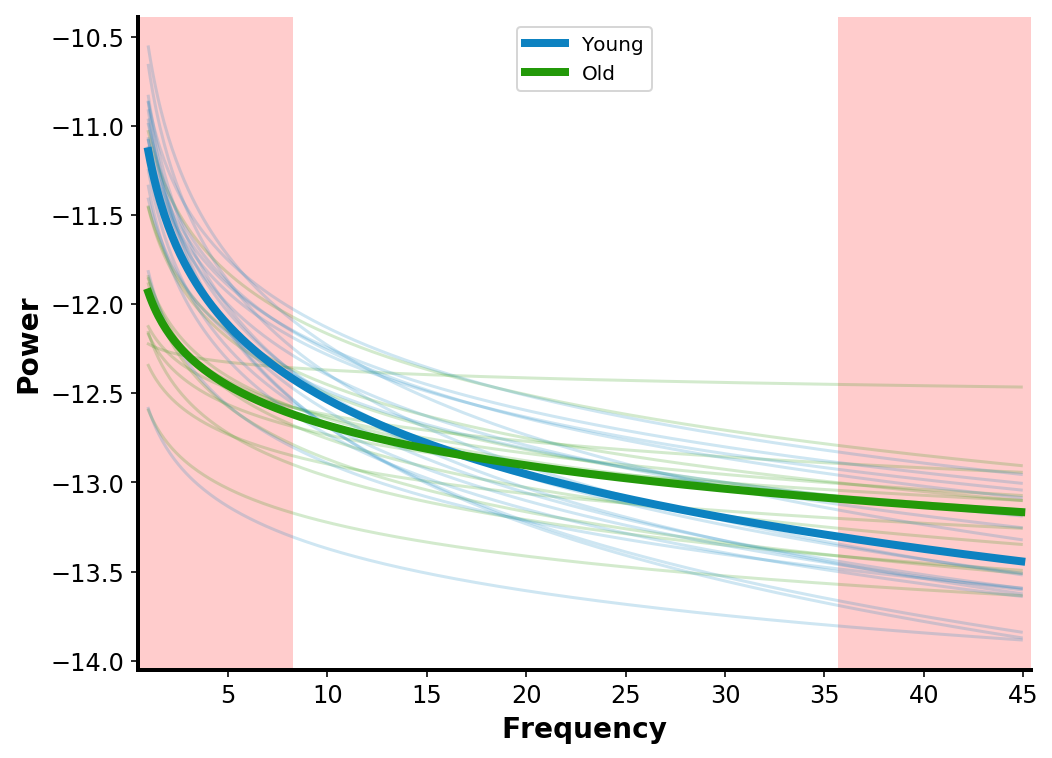

In [34]:
# Plot aperiodics with a the comparison of differences at each frequency
plot_aperiodic(aps, save_fig=save_fig, save_name='Aperiodics')

### Compare 'Peaks' from Aperiodic

Question: compare with just exponent, or with exponent & offset?

In [35]:
# Pull out the difference in power, at 10 Hz, arising from BG difference
exp_alphas = []
for ap in aps:
    exp_alphas.append(expo_nk_function(np.array([10]), *ap)[0])
    #exp_alphas.append(expo_nk_function(np.array([10]), 1, ap[1])[0])
    #exp_alphas.append(expo_nk_function(np.array([10]), ap[0], 1)[0])
exp_alphas = np.array(exp_alphas)

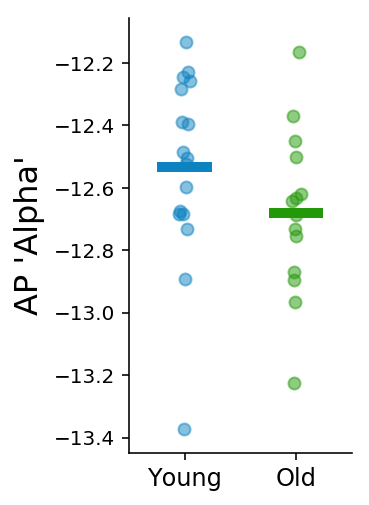

In [36]:
# Compare the 'alpha' difference - coming only from aperiodic differences
plot_comp_scatter(exp_alphas, "AP 'Alpha'", save_fig=save_fig, save_name='APAlpha')

In [37]:
# Statistically test difference in 'BG-Alpha'
ttest_ind(exp_alphas[YNG_INDS], exp_alphas[OLD_INDS])

Ttest_indResult(statistic=1.406382915061923, pvalue=0.17023626592830882)

#### Compare across all frequencies

Note: Old version of figure. 

In [38]:
# Calculate aperiodic components of power spectra for each subject
freqs = range(2, 50, 2)
model_aps = []
for ap in aps:
    model_aps.append(expo_nk_function(np.array(freqs), *ap))
    #model_aps.append(expo_nk_function(np.array(freqs), 0, ap[1]))
    #model_aps.append(expo_nk_function(np.array(freqs), ap[0], 1))
model_aps = np.array(model_aps)

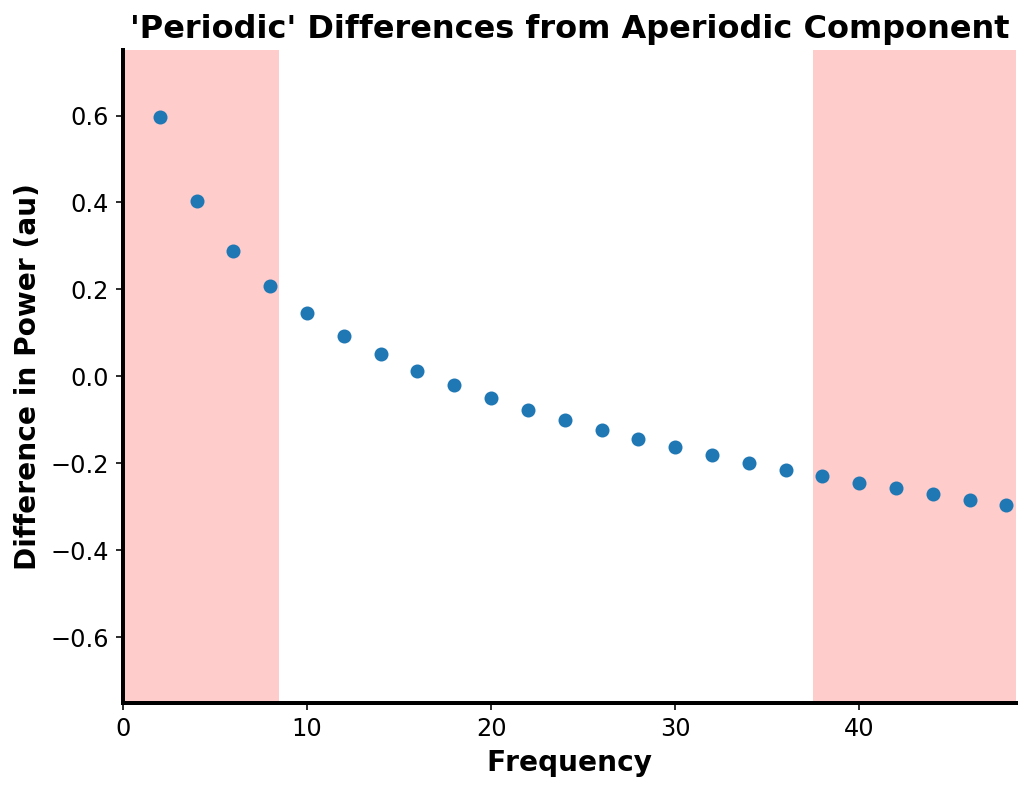

In [39]:
# Calculate average difference per frequency, and plot comparison
avg_diffs, p_vals = calc_ap_comps(freqs, model_aps)
plot_ap_band_diff(freqs, avg_diffs, p_vals)

## Controls - check errors

Check that there isn't a systematic different in model fit error / R^2 that could explain differences

In [40]:
# Extract error & R^2 from FOOOF fits
ch_ind = 28  # Oz

errs = []; r2s = []

for fg in fgs:
    errs.append(fg.get_results()[ch_ind].error)
    r2s.append(fg.get_results()[ch_ind].r_squared)

errs = np.array(errs)
r2s = np.array(r2s)

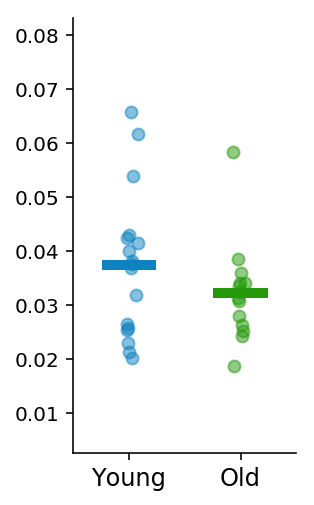

In [41]:
# Compare errors between groups
plot_comp_scatter(errs)

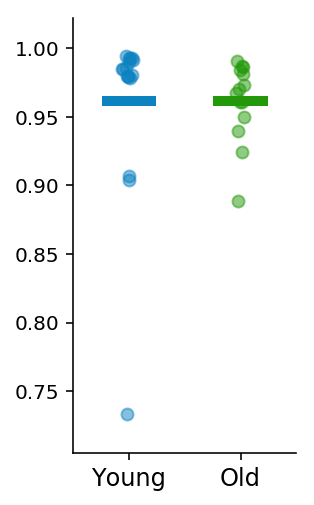

In [42]:
# Compare errors between groups
plot_comp_scatter(r2s)

In [43]:
# Statistically compare errors and R^2 between groups
print_stat('Errors', *ttest_ind(errs[YNG_INDS], errs[OLD_INDS]))
print_stat('R-squared', *ttest_ind(r2s[YNG_INDS], r2s[OLD_INDS]))

Errors: 	  1.1948 	0.2418
R-squared: 	  0.0008 	0.9993


In [44]:
# Check the correlation between errors and R^2s
print_stat('Errs & R2s ', *pearsonr(errs, r2s))

Errs & R2s : 	 -0.6201 	0.0002


## Correlations between FOOOF Features

In [45]:
# Seperate out Oz BG parameters
oz_offs = oz_aps[:, 0]; oz_exps = oz_aps[:, 1]

In [46]:
# Correlation between aperiodic features
print_stat('Cz - Off & Sl ', *pearsonr(offs, exps))
print_stat('Oz - Off & Sl ', *pearsonr(oz_offs, oz_exps))

Cz - Off & Sl : 	  0.8868 	0.0000
Oz - Off & Sl : 	  0.8520 	0.0000


In [47]:
# Correlations between oscillation features
print_stat('Osc - Cf  & Amp', *pearsonr(alphas[:, 0], alphas[:, 1]))
print_stat('Osc - Cf  & BW ', *pearsonr(alphas[:, 0], alphas[:, 2]))
print_stat('Osc - Amp & BW ', *pearsonr(alphas[:, 1], alphas[:, 2]))

Osc - Cf  & Amp: 	  0.1657 	0.3730
Osc - Cf  & BW : 	  0.3299 	0.0699
Osc - Amp & BW : 	 -0.0544 	0.7714


In [48]:
# Correlations between exponent and oscillation features
print_stat('CF  & Sl ', *pearsonr(alphas[:, 0], oz_exps))
print_stat('Amp & Sl ', *pearsonr(alphas[:, 1], oz_exps))
print_stat('BW  & Sl ', *pearsonr(alphas[:, 2], oz_exps))

CF  & Sl : 	  0.3944 	0.0281
Amp & Sl : 	  0.0915 	0.6245
BW  & Sl : 	  0.4672 	0.0081


In [49]:
# Oz alpha with Cz exponent (?)
print_stat('Oz CF  & Cz Sl', *pearsonr(alphas[:, 0], exps))
print_stat('Oz Amp & Cz Sl', *pearsonr(alphas[:, 1], exps))
print_stat('Oz BW  & Cz Sl', *pearsonr(alphas[:, 2], exps))

Oz CF  & Cz Sl: 	  0.3338 	0.0664
Oz Amp & Cz Sl: 	  0.3650 	0.0435
Oz BW  & Cz Sl: 	  0.3260 	0.0735


In [50]:
# Correlation between FOOOF outputs and error
print_stat('Oz Cf  & Err', *pearsonr(errs, alphas[:, 0]))
print_stat('Oz Amp & Err', *pearsonr(errs, alphas[:, 1]))
print_stat('Oz BW  & Err', *pearsonr(errs, alphas[:, 2]))
print_stat('Oz Sl  & Err', *pearsonr(errs, oz_exps))

Oz Cf  & Err: 	 -0.2017 	0.2766
Oz Amp & Err: 	  0.3339 	0.0664
Oz BW  & Err: 	 -0.2608 	0.1565
Oz Sl  & Err: 	 -0.2105 	0.2556


In [51]:
# Correlation between FOOOF outputs and r2s
print_stat('Oz Cf   & R^2', *pearsonr(r2s, alphas[:, 0]))
print_stat('Oz Amp  & R^2', *pearsonr(r2s, alphas[:, 1]))
print_stat('Oz BW   & R^2', *pearsonr(r2s, alphas[:, 2]))
print_stat('Oz Sl   & R^2', *pearsonr(r2s, oz_exps))

Oz Cf   & R^2: 	  0.3917 	0.0293
Oz Amp  & R^2: 	  0.2822 	0.1241
Oz BW   & R^2: 	  0.3919 	0.0292
Oz Sl   & R^2: 	  0.5332 	0.0020


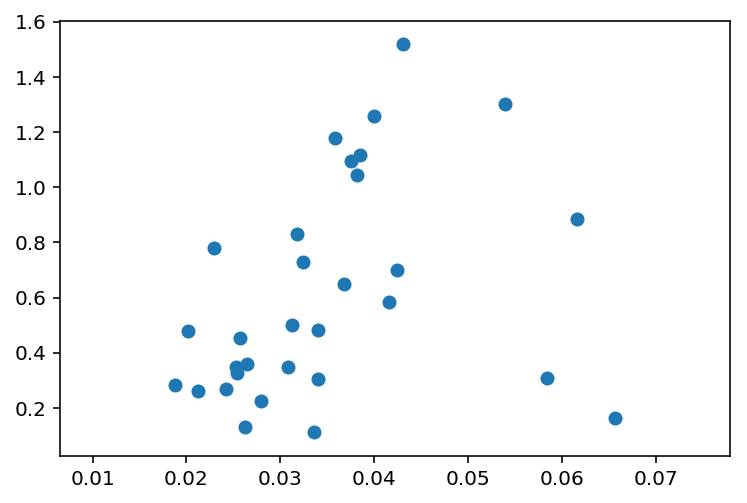

In [52]:
# Scatter plot of inter-measure correlations
plt.scatter(errs, alphas[:, 1])